# Exercise multimodal recognition: RGB-D scene recognition

This exercise consists of three parts: two tutorials and the deliverable. The students must modify the code of the tutorial part, and write and discuss the results in the deliverable part that will be used to evaluate the exercise.

If you are not familiar with jupyter notebooks please check __[this tutorial](https://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/What%20is%20the%20Jupyter%20Notebook.html)__ first.

# Part 2 (tutorial): RGB-D baseline

If you haven followed the tutorial related with single modality, please run **single.ipynb** first for the first part.

In this tutorial, you will build a two-branch RGB-D network using PyTorch. The code is loosely based on the __[PyTorch transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)__. Just execute the code sequentially, paying attention to the comments.

In [1]:
from __future__ import print_function, division

import copy
import itertools
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader

from utils import STD_RGB, STD_DEPTH, MEAN_RGB, MEAN_DEPTH, Compose, CenterCrop, Resize, ToTensor, RandomResizedCrop, \
    RandomHorizontalFlip, Normalize, ImageFolder, imshow_rgb_d

plt.ion()  # interactive mode


Load Data
---------

We will use torchvision, torch.utils.data and RGBDutils packages for loading the
data. The dataset is structured hierarchically in splits\modalities\classes (check the folder).

In [4]:
# Data augmentation and normalization for training

data_transforms = {
    'train': Compose([
        RandomResizedCrop(227),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(MEAN_RGB, STD_RGB, MEAN_DEPTH, STD_DEPTH)]),
    'val': Compose([
        Resize(256),
        CenterCrop(227),
        ToTensor(),
        Normalize(MEAN_RGB, STD_RGB, MEAN_DEPTH, STD_DEPTH)]),
    'test': Compose([
        Resize(256),
        CenterCrop(227),
        ToTensor(),
        Normalize(MEAN_RGB, STD_RGB, MEAN_DEPTH, STD_DEPTH)]),
}

# Path to the dataset
data_dir = '/home/mcv/datasets/sunrgbd_lite'

# Preparing dataset and dataloaders
partitions = ['train', 'val', 'test']
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in partitions}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in partitions}
dataset_sizes = {x: len(image_datasets[x]) for x in partitions}
class_names = image_datasets['train'].classes

use_gpu = cuda.is_available()


In [5]:
image_datasets


{'test': Dataset ImageFolder
     Number of datapoints: 1587
     Root Location: /home/mcv/datasets/sunrgbd_lite/test,
 'train': Dataset ImageFolder
     Number of datapoints: 745
     Root Location: /home/mcv/datasets/sunrgbd_lite/train,
 'val': Dataset ImageFolder
     Number of datapoints: 868
     Root Location: /home/mcv/datasets/sunrgbd_lite/val}

**Visualize a few samples**

Let's visualize a few RGB-D pairs so as to RGB-D data and data augmentations.



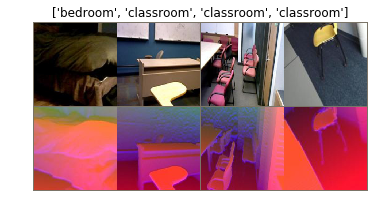

In [6]:
# Get a batch of training data and visualize the first four pairs
inputsRGB, inputsDepth, classes = next(iter(dataloaders['train']))
inputsRGB, inputsDepth, classes = inputsRGB[0:4], inputsDepth[0:4], classes[0:4]

# Make a grid from batch
outRGB = torchvision.utils.make_grid(inputsRGB)
outDepth = torchvision.utils.make_grid(inputsDepth)

imshow_rgb_d(outRGB, outDepth, title=[class_names[x] for x in classes], concat_vert=True)


Training the model
------------------

Now, let's write a general function to train a model. Details:

-  Uses Adam algorithm for gradient descent.
-  Early stoping using best validation accuracy

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print('Phase %s' % phase)
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs_rgb, inputs_hha, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs_rgb = Variable(inputs_rgb.cuda())
                    inputs_hha = Variable(inputs_hha.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs_rgb, inputs_hha, labels = Variable(inputs_hha), Variable(inputs_hha), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model((inputs_rgb, inputs_hha))
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                # running_loss += loss.data[0] * inputs_rgb.size(0) # Pytorch 0.4
                running_loss += loss.data.item() * inputs_rgb.size(0)  # Pytorch 1.0
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


And now, a function to evaluate the model on a particular set.

In [8]:
def evaluate_model(model, partition, criterion):
    since = time.time()

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for data in dataloaders[partition]:
        # get the inputs
        inputs_rgb, inputs_hha, labels = data
        # wrap them in Variable
        if use_gpu:
            inputs_rgb = Variable(inputs_rgb.cuda())
            inputs_hha = Variable(inputs_hha.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs_rgb, inputs_hha, labels = Variable(inputs_hha), Variable(inputs_hha), Variable(labels)

        # forward
        outputs = model((inputs_rgb, inputs_hha))
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        # running_loss += loss.data[0] * inputs_rgb.size(0) # Pytorch 0.4
        running_loss += loss.data.item() * inputs_rgb.size(0)  # Pytorch 1.0
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes[partition]
    test_acc = running_corrects.item() / dataset_sizes[partition]

    print()

    time_elapsed = time.time() - since
    print('Tested in {:.0f}m {:.0f}s Loss: {:.4f} Acc: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, test_loss, test_acc))

    return test_acc, test_loss


Building the RGB-D model
----------------------

The architecture of the network is shown in the following figure:
<img src="figures/rgbd_network.png" />

The following code creates the RGB-D network by instantiating two AlexNets, that are combined using concatenation just before the classifier. There are some tricky steps due to the way the pretrained AlexNet is implemented in PyTorch. 


In [26]:
# In PyTorch every network is implementd as a nn.Module
class RGBDnet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, num_classes):
        super(RGBDnet, self).__init__()

        # RGB branch
        self.model_rgb = torchvision.models.densenet121(pretrained=True)
        for param in self.model_rgb.parameters():
            param.requires_grad = False
        
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = self.model_rgb.classifier.in_features
        self.model_rgb.classifier = nn.Linear(num_ftrs, num_ftrs)

        # HHA branch
        self.model_hha = torchvision.models.densenet121(pretrained=True)
        for param in self.model_hha.parameters():
            param.requires_grad = False
        
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = self.model_hha.classifier.in_features
        self.model_hha.classifier = nn.Linear(num_ftrs, num_ftrs)

        # Classifier
        self.classifier = nn.Linear(2 * num_ftrs, num_classes)

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
        x_rgb = self.model_rgb(x[0])
        x_hha = self.model_hha(x[1])
        x = torch.cat((x_rgb, x_hha), 1)
        x = self.classifier(x)
        return x


In [27]:
# Instantiate the model
num_classes = len(class_names)
model = RGBDnet(num_classes=num_classes)

# You can visualize the resulting network
print(model)


RGBDnet(
  (model_rgb): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True

Set up the training/fine tuning parameters
----------------------

The following code creates the optimization criterio and set per-layer training rates to better control the fine tuning and training process. We use a very simple model in which all layers are frozen except the last fully connected one, i.e. the classifier, so it should be easy to improve the performance.

In [28]:
# Here we define the learning rate
for param in model.parameters():  # Freeze all parameters by default
    param.requires_grad = False

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = Adam(model.parameters(), lr=learning_rate)


Train and evaluate the model
-----------------

It shouldn't take more than 2 mins to train with the GPU in the server.

In [29]:
# Train
model = train_model(model, criterion, optimizer, None, num_epochs=25)

# Evaluate
train_acc, _ = evaluate_model(model, 'train', criterion)
val_acc, _ = evaluate_model(model, 'val', criterion)
test_acc, _ = evaluate_model(model, 'test', criterion)
print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' %
      (train_acc * 100, val_acc * 100, test_acc * 100))


Epoch 0/24
----------
Phase train


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# Part 2 (deliverable)

This part will be evaluated as deliverable. Please check you include the required results and information. In principle I don't intent to run your code, just check your numbers and descriptions.

* Comparison of RGB, HHA and RGB-D baselines. Include a table with the train, validation and test average accuracies (and standard deviations) over 5 runs for each case (RGB only, HHA only and RGB-D).
* Description of the improvements of the RGB-D network, experimental results and discussion (0.25 points)
* Team work: description of the contribution of each member of the team.

The maximum of the exercise is 0.5 points.
